In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use('seaborn')

%matplotlib inline

## Generate data

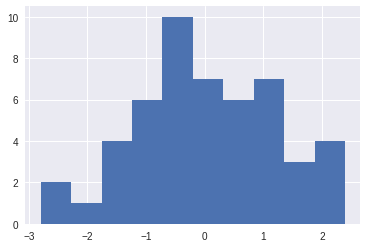

In [2]:
np.random.seed(123)

data = np.random.randn(50)
plt.hist(data, bins=10);

Goal is to find the posterior distribution of the mean $\mu$ (assuming we know standard deviation $\sigma$ is 1)

## Simplified Markov Chain Monte Carlo

1. Start at arbitrary value for $\mu$
2. Select a new proposed value for $\mu$ by simply picking from a Normal distribution centred around the current $\mu$ value with $\sigma$ being the proposal width
3. Evaluate whether the probability of the proposed value explains the data $x$ better than the current value (see below for details)
4. If the proposed value is better, we move to it. If not, we still sometimes want to move to it (even though it's worse) so we can get a posterior distribution. The acceptance probability to move is given by:

$$\frac{P(\mu_{prop}|x)}{P(\mu_{curr}|x)} = \frac{\frac{P(x|\mu_{prop}) P(\mu_{prop})}{P(x)}}{\frac{P(x|\mu_{curr}) P(\mu_{curr})}{P(x)}} = \frac{P(x|\mu_{prop}) P(\mu_{prop})}{P(x|\mu_{curr}) P(\mu_{curr})}$$

In [3]:
SAMPLES = 1000
PROPOSAL_WIDTH = 0.5

# Step 1: Set up current value
mu_curr = 1.0
trace = [mu_curr]

for i in range(SAMPLES):
    
    # Step 2: Select new proposed value
    mu_prop = norm(mu_curr, PROPOSAL_WIDTH).rvs()
    
    # Step 3: Evaluate fit to data
    likelihood_curr = norm(mu_curr, 1).pdf(data).prod()
    likelihood_prop = norm(mu_prop, 1).pdf(data).prod()
    
    prior_curr = norm(0, 1).pdf(mu_curr)
    prior_prop = norm(0, 1).pdf(mu_prop)
    
    p_curr = likelihood_curr * prior_curr
    p_prop = likelihood_prop * prior_prop
    
    # Step 4: Move or stay
    p_accept = min(p_prop/p_curr, 1)
    
    if np.random.rand() < p_accept:
        mu_curr = mu_prop
    
    # Record onto trace
    trace.append(mu_curr)

The proposal width controls the step size. Too small and it will take a long time to explore the space. Too large and it will keep jumping around. A sampler is more efficient when the samples are independent from each other (low autocorrelation). A rule of thumb is to aim for 50% proposal rejection.

## Results

The generated trace represents samples taken from the posterior distribution. The longer the trace, the better the representation. Note it takes a few samples to "settle" into the distribution so it's common the burn them.

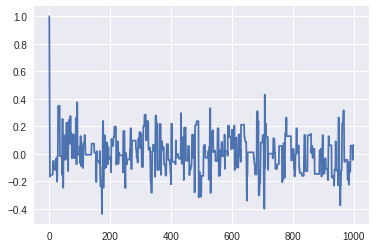

In [4]:
plt.plot(trace);

Taking the histogram of the trace produces an approximation of the posterior distribution, i.e. our belief in what $\mu$ is

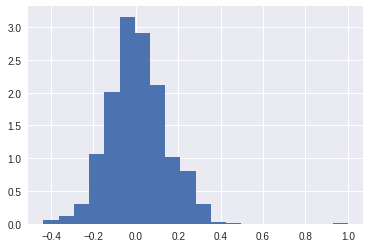

In [5]:
plt.hist(trace, bins=20, density=True);

In this example we can get the exact posterior distribution analytically and can check how well it compares

In [6]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)

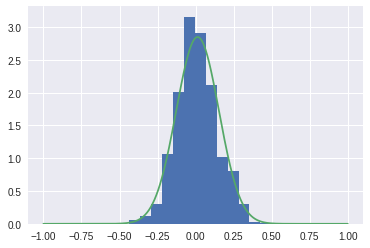

In [7]:
plt.hist(trace, bins=20, density=True)
plt.plot(x, posterior_analytical)
plt.show();

Reference:
https://twiecki.io/blog/2015/11/10/mcmc-sampling/